In [25]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [26]:
rng = np.random.default_rng(12345)

# Initialize Constants

In [27]:
NUM_DAYS_TOTAL = 30
SOIL_POROSITY = 0.4
SOIL_DEPTH_MM = 800
HYGROSCOPIC_POINT = 0.02
WILTING_POINT = 0.065
MAX_MOISTURE_WITH_CLOSED_STOMATA = 0.17
FIELD_CAPACITY = 0.3
MAXIMUM_EVAPORATION_RATE_MM_PER_DAY = 1.0
MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY = 3.5
SATURATED_HYDRAULIC_CONDUCTIVITY_MM_PER_DAY = 1100
PORE_SIZE_DISTRIBUTION_INDEX = 7.75 # 4.05 for porporato conditions
BETA = 4.0 * PORE_SIZE_DISTRIBUTION_INDEX + 4.0
ADDED_RESIDUE_CARBON_G_PER_M2_PER_DAY = 1.5
PROPORTION_BIOMASS_DYING_PER_DAY = 0.0085
PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY = 0.000065
PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY = 0.0000025
MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY = 1.0
MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY = 1.0
PROPORTION_AMMONIUM_NITRIFIED_PER_BIOMASS_PER_DAY = 0.006 # porporato had 0.6
DISSOLVED_FRACTION_AMMONIUM = 0.05
DISSOLVED_FRACTION_NITRATE = 1.0
RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON = 0.6
NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON = 1- RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON
MAX_HUMIFIED_FRACTION_OF_DECOMPOSED_LITTER = 0.25
ADDED_RESIDUE_CN_RATIO = 58
BIOMASS_CN_RATIO = 11.5
HUMUS_CN_RATIO = 22 # porporato had 22
EXCESS_BIO_NITROGEN_PER_HUMUS_CARBON_DECOMPOSED = 1 / HUMUS_CN_RATIO - NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON / BIOMASS_CN_RATIO
PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY = 0.2
PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY = 0.5
DIFFUSION_COEFFICIENT_MM_PER_DAY = 100 # possibly should be 100 ? Porporato has 0.1 meters/day
DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT = 3
RAIN_EXISTENCE_RATE = 0.23
RAIN_MEAN_DEPTH_MM = 11 # porporato had 11

# Functions

In [28]:
f_d = np.vectorize(lambda s : s / FIELD_CAPACITY if s <= FIELD_CAPACITY else FIELD_CAPACITY / s)
f_n = np.vectorize(lambda s: s / FIELD_CAPACITY if s <= FIELD_CAPACITY else (1 - s)/(1- FIELD_CAPACITY))

# States

In [29]:
soil_moisture = np.zeros(NUM_DAYS_TOTAL)
litter_carbon_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
biomass_carbon_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
humus_carbon_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
litter_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
ammonium_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
nitrate_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)

# fake states
biomass_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)
humus_nitrogen_g_per_m3 = np.zeros(NUM_DAYS_TOTAL)

# Step Intermediate Variables

In [30]:
rain_events = np.zeros(NUM_DAYS_TOTAL)
rain_quantity_mm = np.zeros(NUM_DAYS_TOTAL)
infiltration_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
evaporation_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
transpiration_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
leakage_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
volume_water_per_unit_area_mm = np.zeros(NUM_DAYS_TOTAL)
moisture_effect_on_decomposition_factor = np.zeros(NUM_DAYS_TOTAL)
moisture_effect_on_nitrification_factor = np.zeros(NUM_DAYS_TOTAL)
max_active_ammonium_uptake_proportion_per_day = np.zeros(NUM_DAYS_TOTAL)
max_active_nitrate_uptake_proportion_per_day = np.zeros(NUM_DAYS_TOTAL)
litter_cn_ratio = np.zeros(NUM_DAYS_TOTAL)
humified_fraction_of_decomposed_litter = np.zeros(NUM_DAYS_TOTAL)
biomassified_fraction_of_decomposed_litter_carbon = np.zeros(NUM_DAYS_TOTAL)
available_mineral_nitrogen_g_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
maximum_immobilization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
surplus_N_at_max_decomposition_rate_g_N_per_biomass_per_day_per_m3 = np.zeros(NUM_DAYS_TOTAL) # i.e. the surplus N beyond what is needed to maintain the C/N ratios of the biomass and humus pools. If this is positive, mineralization occurs; if it is negative, immobilization occurs
immobilization_demand_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
phi = np.zeros(NUM_DAYS_TOTAL)
net_flux_to_mineralized_nitrogen_g_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
total_immobilization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
max_active_ammonium_uptake_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
max_active_nitrate_uptake_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
plant_active_ammonium_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
plant_active_nitrate_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)

# Flows

In [31]:
added_residues_g_C_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
biomass_death_rate_g_carbon_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
litter_decomposition_rate_g_carbon_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
humus_decomposition_rate_g_carbon_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
mineralization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
ammonium_immobilization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
nitrate_immobilization_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
nitrification_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
ammonium_leaching_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
nitrate_leaching_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
ammonium_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)
nitrate_uptake_rate_g_N_per_m3_per_day = np.zeros(NUM_DAYS_TOTAL)

# Initial Conditions

In [32]:
soil_moisture[0] = 0.15
litter_carbon_g_per_m3[0] = 1300
biomass_carbon_g_per_m3[0] = 50
humus_carbon_g_per_m3[0] = 8500
litter_nitrogen_g_per_m3[0] = litter_carbon_g_per_m3[0] / 34.0 # porporato had 34
ammonium_nitrogen_g_per_m3[0] = 28.025 # equivalent to 200 lbs/acre of N
# ammonium_nitrogen_g_per_m3[0] = 0.1
nitrate_nitrogen_g_per_m3[0] = 1.0 # porporato had <= 1.0

biomass_nitrogen_g_per_m3[0] = biomass_carbon_g_per_m3[0] / BIOMASS_CN_RATIO
humus_nitrogen_g_per_m3[0] = humus_carbon_g_per_m3[0] / HUMUS_CN_RATIO

# Rainfall

<BarContainer object of 30 artists>

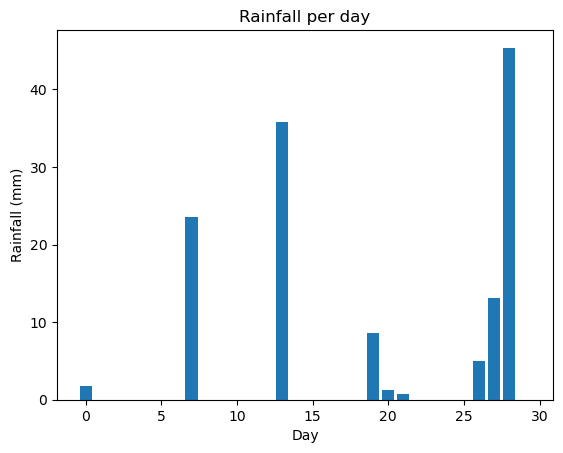

In [33]:
rain_events = rng.random(rain_events.shape) < RAIN_EXISTENCE_RATE
rain_quantity_mm = rng.exponential(RAIN_MEAN_DEPTH_MM, rain_quantity_mm.shape) * rain_events
plt.title("Rainfall per day")
plt.xlabel("Day")
plt.ylabel("Rainfall (mm)")
plt.bar(range(NUM_DAYS_TOTAL), rain_quantity_mm)

In [34]:
def generate_rain():
    rain_events = rng.random(NUM_DAYS_TOTAL) < RAIN_EXISTENCE_RATE
    rain_quantity_mm = rng.exponential(RAIN_MEAN_DEPTH_MM, NUM_DAYS_TOTAL) * rain_events
    return rain_quantity_mm

# Water Modeling

In [35]:
def hydrology_model(initial_soil_moisture: float, rain_quantity_mm: npt.NDArray[np.float64]):
    soil_moisture = np.zeros(NUM_DAYS_TOTAL)
    infiltration_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
    evaporation_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
    transpiration_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)
    leakage_rate_mm_per_day = np.zeros(NUM_DAYS_TOTAL)

    soil_moisture[0] = initial_soil_moisture

    for i in range(NUM_DAYS_TOTAL):
        infiltration_rate_mm_per_day[i] = min(rain_quantity_mm[i], SOIL_POROSITY * SOIL_DEPTH_MM * (1 - soil_moisture[i]))

        # evaporation
        if soil_moisture[i] < HYGROSCOPIC_POINT:
            evaporation_rate_mm_per_day[i] = 0
        elif soil_moisture[i] <= WILTING_POINT:
            evaporation_rate_mm_per_day[i] = MAXIMUM_EVAPORATION_RATE_MM_PER_DAY * (soil_moisture[i] - HYGROSCOPIC_POINT)
        else:
            evaporation_rate_mm_per_day[i] = MAXIMUM_EVAPORATION_RATE_MM_PER_DAY

        # Transpiration
        if soil_moisture[i] <= WILTING_POINT:
            transpiration_rate_mm_per_day[i] = 0
        elif soil_moisture[i] <= MAX_MOISTURE_WITH_CLOSED_STOMATA:
            transpiration_rate_mm_per_day[i] = MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY * (soil_moisture[i] - WILTING_POINT) / (MAX_MOISTURE_WITH_CLOSED_STOMATA - WILTING_POINT)
        else:
            transpiration_rate_mm_per_day[i] = MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY

        # leakage/percolation
        leakage_rate_mm_per_day[i] = SATURATED_HYDRAULIC_CONDUCTIVITY_MM_PER_DAY * (np.exp(BETA * (soil_moisture[i] - FIELD_CAPACITY)) - 1) / (np.exp(BETA * (1 - FIELD_CAPACITY)) - 1)

        if i + 1 < NUM_DAYS_TOTAL:
            soil_moisture[i+1] = soil_moisture[i] + (infiltration_rate_mm_per_day[i] - evaporation_rate_mm_per_day[i] - transpiration_rate_mm_per_day[i] - leakage_rate_mm_per_day[i]) / (SOIL_POROSITY * SOIL_DEPTH_MM)

    moisture_effect_on_decomposition_factor = f_d(soil_moisture)
    moisture_effect_on_nitrification_factor = f_n(soil_moisture)

    return soil_moisture, infiltration_rate_mm_per_day, evaporation_rate_mm_per_day, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor


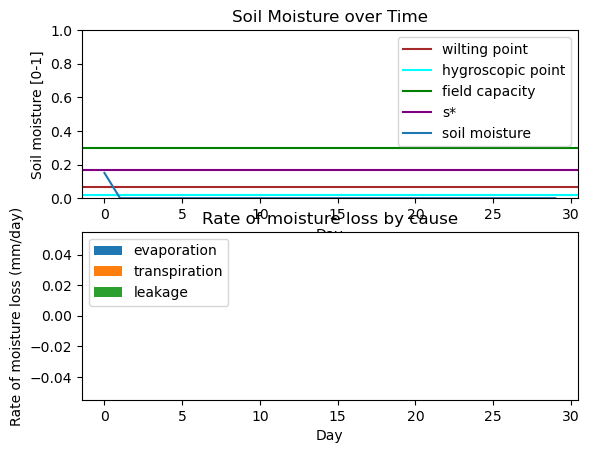

In [36]:
plt.figure()
ax = plt.subplot(2, 1, 1)
plt.title("Soil Moisture over Time")
plt.xlabel("Day")
plt.ylabel("Soil moisture [0-1]")
plt.ylim(0,1)
plt.axhline(y=WILTING_POINT, label="wilting point", color="brown")
plt.axhline(y=HYGROSCOPIC_POINT, label="hygroscopic point", color="cyan")
plt.axhline(y=FIELD_CAPACITY, label="field capacity", color="green")
plt.axhline(y=MAX_MOISTURE_WITH_CLOSED_STOMATA, label="s*", color="purple")
plt.plot(range(NUM_DAYS_TOTAL), soil_moisture, label="soil moisture")
plt.legend(loc="upper right")

plt.subplot(2, 1, 2, sharex=ax)
plt.stackplot(range(NUM_DAYS_TOTAL), evaporation_rate_mm_per_day, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, baseline="zero", labels = ["evaporation", "transpiration", "leakage"])
plt.title("Rate of moisture loss by cause")
plt.xlabel("Day")
plt.ylabel("Rate of moisture loss (mm/day)")
plt.legend(loc="upper left")

In [37]:
volume_water_per_unit_area_mm = soil_moisture * SOIL_DEPTH_MM * SOIL_POROSITY
moisture_effect_on_decomposition_factor = f_d(soil_moisture)
moisture_effect_on_nitrification_factor = f_n(soil_moisture)
max_active_ammonium_uptake_proportion_per_day = DISSOLVED_FRACTION_AMMONIUM * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)
max_active_nitrate_uptake_proportion_per_day = DISSOLVED_FRACTION_NITRATE * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)

if not np.all([moisture_effect_on_decomposition_factor <= 1.0, moisture_effect_on_decomposition_factor >= 0.0, moisture_effect_on_nitrification_factor <= 1.0, moisture_effect_on_nitrification_factor >= 0.0]):
    print("out of range!")

/tmp/nix-shell.Ice7eQ/ipykernel_1662200/1400895427.py:4: RuntimeWarning: divide by zero encountered in divide
  max_active_ammonium_uptake_proportion_per_day = DISSOLVED_FRACTION_AMMONIUM * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)
/tmp/nix-shell.Ice7eQ/ipykernel_1662200/1400895427.py:4: RuntimeWarning: invalid value encountered in multiply
  max_active_ammonium_uptake_proportion_per_day = DISSOLVED_FRACTION_AMMONIUM * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)
/tmp/nix-shell.Ice7eQ/ipykernel_1662200/1400895427.py:5: RuntimeWarning: divide by zero encountered in divide
  max_active_nitrate_uptake_proportion_per_day = DISSOLVED_FRACTION_NITRATE * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)
/tmp/nix-shell.Ice7eQ/ipykernel_1662200/1400895427.py:5:

In [38]:
def print_step(i):
    print("Litter C state (gC/m^3):\t\t", litter_carbon_g_per_m3[i])
    print("Litter N state (gN/m^3):\t\t", litter_nitrogen_g_per_m3[i])
    print("Litter C/N Ratio:\t\t", litter_cn_ratio[i])
    print("Humified fraction of decomposed litter [0,1]:\t\t", humified_fraction_of_decomposed_litter[i])
    print("Ammonium state (gN/m^3):\t\t", ammonium_nitrogen_g_per_m3[i])
    print("Nitrate state (gN/m^3):\t\t", nitrate_nitrogen_g_per_m3[i])
    print("Humus C state (gC/m^3):\t\t", humus_carbon_g_per_m3[i])
    print("phi [0,1]:\t\t", phi[i])


# Soil Organic Matter Model

In [39]:
def soil_organic_model(initial_litter_carbon_gC_per_m3: float, initial_litter_nitrogen_gN_per_m3: float, initial_microbial_carbon_gC_per_m3: float, initial_humus_carbon_gC_per_m3: float, moisture_decomposition_factor: npt.NDArray[np.float64], added_residue_nitrogen_gN_per_m3_per_day: npt.NDArray[np.float64], added_residue_carbon_gC_per_m3_per_day: npt.NDArray[np.float64]):
    array_length = len(moisture_decomposition_factor)
    assert len(added_residue_nitrogen_gN_per_m3_per_day) == array_length
    assert len(added_residue_carbon_gC_per_m3_per_day) == array_length

    # Set up arrays
    litter_cn_ratio_gC_per_gN = np.ndarray(array_length, np.float64)
    humified_fraction_of_decomposed_litter_carbon = np.ndarray(array_length, np.float64)
    microbified_fraction_of_decomposed_litter_carbon = np.ndarray(array_length, np.float64)
    litter_decomposition_carbon_gC_per_m3_per_day = np.ndarray(array_length, np.float64)
    humus_decomposition_carbon_gC_per_m3_per_day = np.ndarray(array_length, np.float64)
    microbial_death_carbon_gC_per_m3_per_day = np.ndarray(array_length, np.float64)
    excess_bio_nitrogen_per_litter_carbon_decomposed_gN_per_gC = np.ndarray(array_length, np.float64)
    net_flux_to_mineral_nitrogen_gN_per_m3_per_day = np.ndarray(array_length, np.float64)
    litter_carbon_gC_per_m3 = np.ndarray(array_length, np.float64)
    litter_nitrogen_gN_per_m3 = np.ndarray(array_length, np.float64)
    microbial_carbon_gC_per_m3 = np.ndarray(array_length, np.float64)
    humus_carbon_gC_per_m3 = np.ndarray(array_length, np.float64)

    # Assign initial values
    litter_carbon_gC_per_m3[0] = initial_litter_carbon_gC_per_m3
    litter_nitrogen_gN_per_m3[0] = initial_litter_nitrogen_gN_per_m3
    microbial_carbon_gC_per_m3[0] = initial_microbial_carbon_gC_per_m3
    humus_carbon_gC_per_m3[0] = initial_humus_carbon_gC_per_m3

    # Simulate
    for i in range(array_length):
        # intermediaries
        litter_cn_ratio_gC_per_gN[i] = litter_carbon_gC_per_m3[i] / litter_nitrogen_gN_per_m3[i]
        humified_fraction_of_decomposed_litter_carbon[i] = min(MAX_HUMIFIED_FRACTION_OF_DECOMPOSED_LITTER, HUMUS_CN_RATIO / litter_cn_ratio_gC_per_gN[i])
        microbified_fraction_of_decomposed_litter_carbon[i] = NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON - humified_fraction_of_decomposed_litter_carbon[i]
        litter_decomposition_carbon_gC_per_m3_per_day[i] = PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY * moisture_decomposition_factor[i] * microbial_carbon_gC_per_m3[i] * litter_carbon_gC_per_m3[i]
        humus_decomposition_carbon_gC_per_m3_per_day[i] = PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY * moisture_decomposition_factor[i] * microbial_carbon_gC_per_m3[i] * humus_carbon_gC_per_m3[i]
        microbial_death_carbon_gC_per_m3_per_day[i] = PROPORTION_BIOMASS_DYING_PER_DAY * microbial_carbon_gC_per_m3[i]

        # states
        if i + 1 < array_length:
            litter_carbon_gC_per_m3[i + 1] = litter_carbon_gC_per_m3[i] + added_residue_carbon_gC_per_m3_per_day[i] + microbial_death_carbon_gC_per_m3_per_day[i] - litter_decomposition_carbon_gC_per_m3_per_day[i]
            litter_nitrogen_gN_per_m3[i + 1] = litter_nitrogen_gN_per_m3[i] + added_residue_nitrogen_gN_per_m3_per_day[i] + (microbial_death_carbon_gC_per_m3_per_day[i] / BIOMASS_CN_RATIO) - (litter_decomposition_carbon_gC_per_m3_per_day[i] / litter_cn_ratio_gC_per_gN[i])
            microbial_carbon_gC_per_m3[i + 1] = microbial_carbon_gC_per_m3[i] + microbified_fraction_of_decomposed_litter_carbon[i] * litter_decomposition_carbon_gC_per_m3_per_day[i] + NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON * humus_decomposition_carbon_gC_per_m3_per_day[i] - microbial_death_carbon_gC_per_m3_per_day[i]
            humus_carbon_gC_per_m3[i + 1] = humus_carbon_gC_per_m3[i] + humified_fraction_of_decomposed_litter_carbon[i] * litter_decomposition_carbon_gC_per_m3_per_day[i] - humus_decomposition_carbon_gC_per_m3_per_day[i]

        # External flows
        excess_bio_nitrogen_per_litter_carbon_decomposed_gN_per_gC[i] = 1 / litter_cn_ratio_gC_per_gN[i] - humified_fraction_of_decomposed_litter_carbon[i] / HUMUS_CN_RATIO - microbified_fraction_of_decomposed_litter_carbon[i] / BIOMASS_CN_RATIO
        net_flux_to_mineral_nitrogen_gN_per_m3_per_day[i] = EXCESS_BIO_NITROGEN_PER_HUMUS_CARBON_DECOMPOSED * humus_decomposition_carbon_gC_per_m3_per_day[i] + excess_bio_nitrogen_per_litter_carbon_decomposed_gN_per_gC[i] * litter_decomposition_carbon_gC_per_m3_per_day[i]

    return litter_carbon_gC_per_m3, litter_nitrogen_gN_per_m3, microbial_carbon_gC_per_m3, humus_carbon_gC_per_m3, net_flux_to_mineral_nitrogen_gN_per_m3_per_day

In [40]:
litter_carbon_g_per_m3, litter_nitrogen_g_per_m3, biomass_carbon_g_per_m3, humus_carbon_g_per_m3, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(1300, 1300 / 34.0, 50, 8500, moisture_effect_on_decomposition_factor, np.full(NUM_DAYS_TOTAL, ADDED_RESIDUE_CARBON_G_PER_M2_PER_DAY / (SOIL_DEPTH_MM / 1000.) / ADDED_RESIDUE_CN_RATIO), np.full(NUM_DAYS_TOTAL, ADDED_RESIDUE_CARBON_G_PER_M2_PER_DAY / (SOIL_DEPTH_MM / 1000.)))

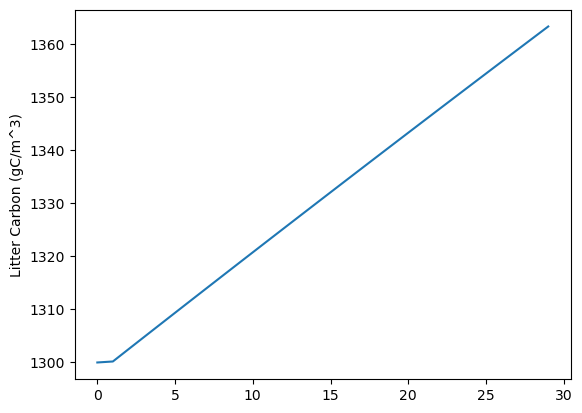

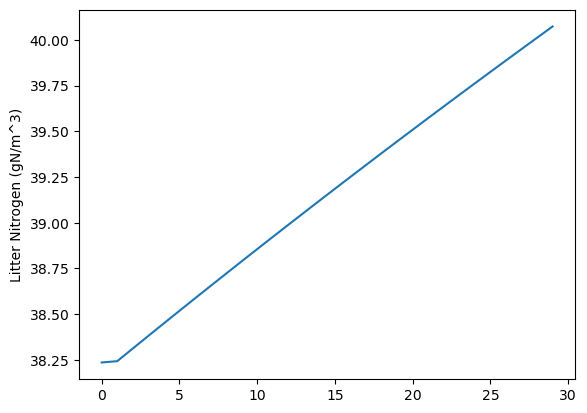

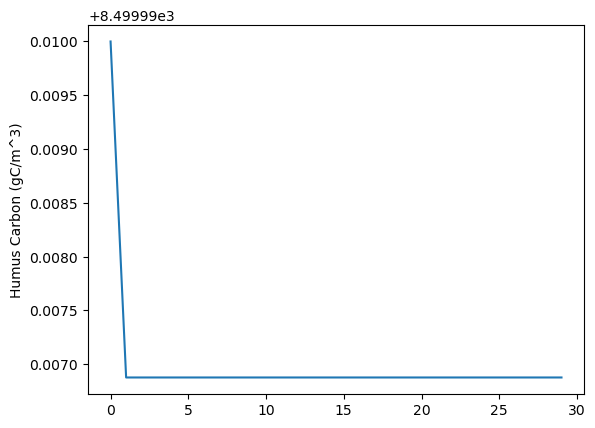

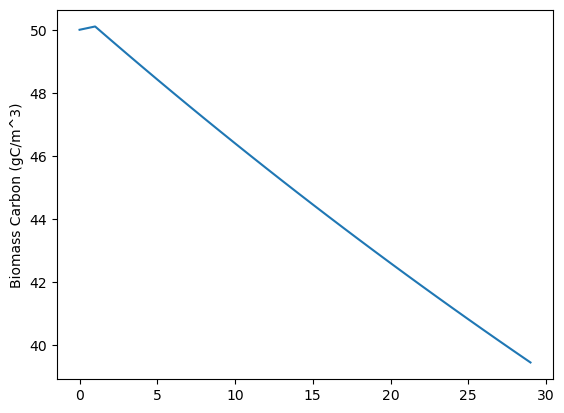

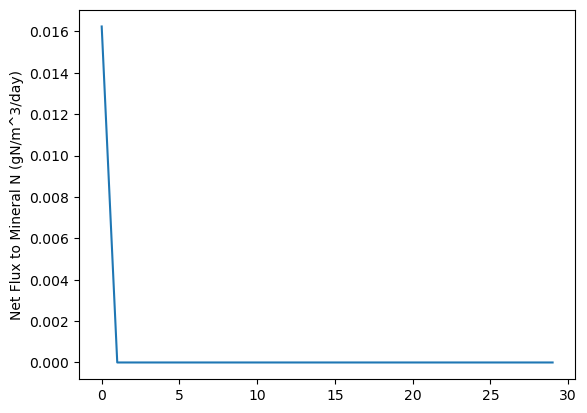

In [41]:
plt.figure()
plt.ylabel("Litter Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), litter_carbon_g_per_m3)
plt.figure()
plt.ylabel("Litter Nitrogen (gN/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), litter_nitrogen_g_per_m3)
plt.figure()
plt.ylabel("Humus Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), humus_carbon_g_per_m3)
plt.figure()
plt.ylabel("Biomass Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), biomass_carbon_g_per_m3)
plt.figure()
plt.ylabel("Net Flux to Mineral N (gN/m^3/day)")
plt.plot(range(NUM_DAYS_TOTAL), net_flux_to_mineralized_nitrogen_g_per_m3_per_day)

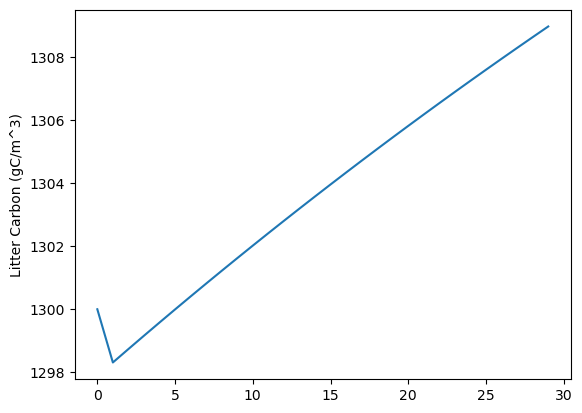

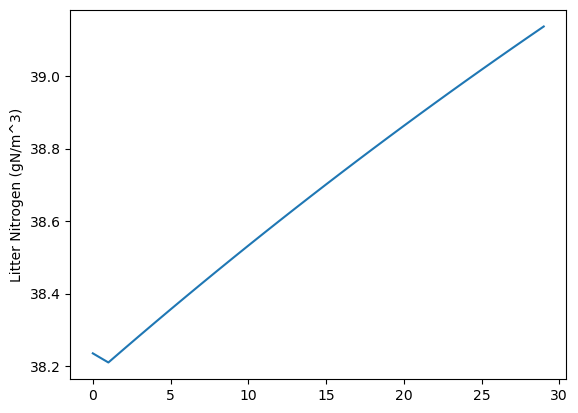

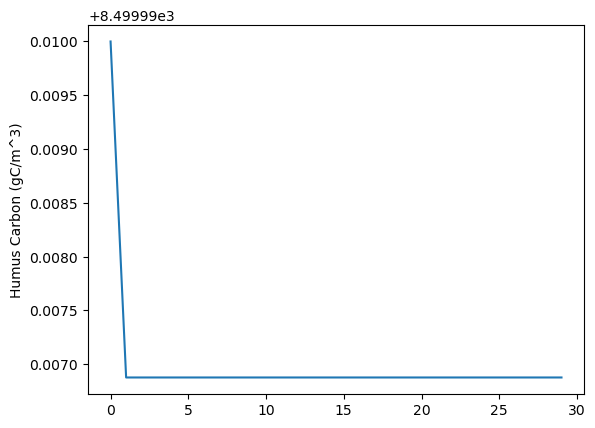

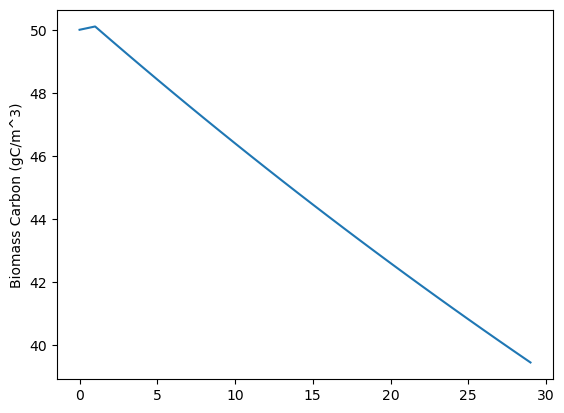

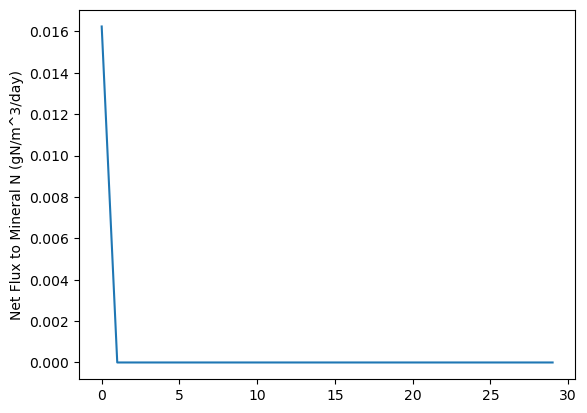

In [42]:
litter_carbon_g_per_m3, litter_nitrogen_g_per_m3, biomass_carbon_g_per_m3, humus_carbon_g_per_m3, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(1300, 1300 / 34.0, 50, 8500, moisture_effect_on_decomposition_factor, np.zeros(NUM_DAYS_TOTAL), np.zeros(NUM_DAYS_TOTAL))
plt.figure()
plt.ylabel("Litter Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), litter_carbon_g_per_m3)
plt.figure()
plt.ylabel("Litter Nitrogen (gN/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), litter_nitrogen_g_per_m3)
plt.figure()
plt.ylabel("Humus Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), humus_carbon_g_per_m3)
plt.figure()
plt.ylabel("Biomass Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), biomass_carbon_g_per_m3)
plt.figure()
plt.ylabel("Net Flux to Mineral N (gN/m^3/day)")
plt.plot(range(NUM_DAYS_TOTAL), net_flux_to_mineralized_nitrogen_g_per_m3_per_day)

# Inorganic Nitrogen Model

In [43]:
def inorganic_nitrogen_model(initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, leakage_mm_per_day: npt.NDArray[np.float64], transpiration_mm_per_day: npt.NDArray[np.float64], soil_moisture: npt.NDArray[np.float64], moisture_nitrification_factor: npt.NDArray[np.float64], moisture_decomposition_factor: npt.NDArray[np.float64], net_flux_to_mineral_nitrogen_gN_per_m3_per_day: npt.NDArray[np.float64], microbial_carbon_gC_per_m3: npt.NDArray[np.float64], input_dt_days: float = 1.0, output_dt_days: float = 1.0):
    array_length = len(leakage_mm_per_day)
    assert len(transpiration_mm_per_day) == array_length
    assert len(soil_moisture) == array_length
    assert len(moisture_nitrification_factor) == array_length
    assert len(moisture_decomposition_factor) == array_length
    assert len(net_flux_to_mineral_nitrogen_gN_per_m3_per_day) == array_length
    assert len(microbial_carbon_gC_per_m3) == array_length

    # scaled arrays
    volume_water_per_unit_area_mm = soil_moisture * SOIL_DEPTH_MM * SOIL_POROSITY
    # constants
    time_stretch = input_dt_days / output_dt_days
    output_array_length = int(array_length * time_stretch)

    # Set up arrays
    available_nitrogen_for_immobilization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    maximum_immobilization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    nitrification_assumptions_violation = np.full(output_array_length, False)
    nitrification_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    mineralization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    total_immobilization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    immobilization_from_ammonium_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_passive_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    maximum_active_ammonium_uptake_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_active_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    ammonium_leaching_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    immobilization_from_nitrate_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_passive_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    maximum_active_nitrate_uptake_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_active_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    nitrate_leaching_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)

    ammonium_gN_per_m3 = np.ndarray(output_array_length, np.float64)
    nitrate_gN_per_m3 = np.ndarray(output_array_length, np.float64)

    # Assign initial values
    ammonium_gN_per_m3[0] = initial_ammonium_gN_per_m3
    nitrate_gN_per_m3[0] = initial_nitrate_gN_per_m3

    # Simulate
    for i in range(output_array_length):
        input_index = int(i / time_stretch)
        available_nitrogen_for_immobilization_gN_per_m3_per_day[i] = MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_gN_per_m3[i] + MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_gN_per_m3[i]
        maximum_immobilization_gN_per_m3_per_day[i] = moisture_decomposition_factor[input_index] * available_nitrogen_for_immobilization_gN_per_m3_per_day[i]
        if net_flux_to_mineral_nitrogen_gN_per_m3_per_day[input_index] > 0:
            mineralization_gN_per_m3_per_day[i] = net_flux_to_mineral_nitrogen_gN_per_m3_per_day[input_index]
            total_immobilization_gN_per_m3_per_day[i] = 0
        else:
            mineralization_gN_per_m3_per_day[i] = 0
            total_immobilization_gN_per_m3_per_day[i] = -net_flux_to_mineral_nitrogen_gN_per_m3_per_day[input_index]
        if total_immobilization_gN_per_m3_per_day[i] > maximum_immobilization_gN_per_m3_per_day[i]:
            print("Insufficient nitrogen to meet immobilization demand, assumptions violated!")
            nitrification_assumptions_violation[i] = True

        nitrification_gN_per_m3_per_day[i] = moisture_nitrification_factor[input_index] * PROPORTION_AMMONIUM_NITRIFIED_PER_BIOMASS_PER_DAY * microbial_carbon_gC_per_m3[input_index] * ammonium_gN_per_m3[i]

        # Duplicated between ammonium and nitrate
        immobilization_from_ammonium_gN_per_m3_per_day[i] = MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_gN_per_m3[i] / available_nitrogen_for_immobilization_gN_per_m3_per_day[i] * total_immobilization_gN_per_m3_per_day[i]
        plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * transpiration_mm_per_day[input_index] / volume_water_per_unit_area_mm[input_index] * ammonium_gN_per_m3[i]
        maximum_active_ammonium_uptake_gN_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm[input_index] * (soil_moisture[input_index] ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT) * ammonium_gN_per_m3[i]
        plant_active_uptake_of_ammonium_gN_per_m3_per_day[i] = max(0, min(maximum_active_ammonium_uptake_gN_per_m3_per_day[i], PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY - plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i]))
        ammonium_leaching_gN_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * leakage_mm_per_day[input_index] / volume_water_per_unit_area_mm[input_index] * ammonium_gN_per_m3[i]

        immobilization_from_nitrate_gN_per_m3_per_day[i] = MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_gN_per_m3[i] / available_nitrogen_for_immobilization_gN_per_m3_per_day[i] * total_immobilization_gN_per_m3_per_day[i]
        plant_passive_uptake_of_nitrate_gN_per_m3_per_day[i] = DISSOLVED_FRACTION_NITRATE * transpiration_mm_per_day[input_index] / volume_water_per_unit_area_mm[input_index] * nitrate_gN_per_m3[i]
        maximum_active_nitrate_uptake_gN_per_m3_per_day[i] = DISSOLVED_FRACTION_NITRATE * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm[input_index] * (soil_moisture[input_index] ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT) * nitrate_gN_per_m3[i]
        plant_active_uptake_of_nitrate_gN_per_m3_per_day[i] = max(0, min(maximum_active_nitrate_uptake_gN_per_m3_per_day[i], PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY - plant_passive_uptake_of_nitrate_gN_per_m3_per_day[i]))
        nitrate_leaching_gN_per_m3_per_day[i] = DISSOLVED_FRACTION_NITRATE * leakage_mm_per_day[input_index] / volume_water_per_unit_area_mm[input_index] * nitrate_gN_per_m3[i]

        # States
        if (i + 1) < output_array_length:
            ammonium_scaling_fix = 1.0
            ammonium_gN_per_m3[i + 1] = ammonium_gN_per_m3[i] + (mineralization_gN_per_m3_per_day[i] - immobilization_from_ammonium_gN_per_m3_per_day[i] - nitrification_gN_per_m3_per_day[i] - ammonium_leaching_gN_per_m3_per_day[i] - plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i] - plant_active_uptake_of_ammonium_gN_per_m3_per_day[i]) * output_dt_days
            if ammonium_gN_per_m3[i + 1] < 0:
                ammonium_scaling_fix = ammonium_gN_per_m3[i] / (ammonium_gN_per_m3[i] - ammonium_gN_per_m3[i + 1])
                print("Ammonium underflow error! Applying scaling fix of", ammonium_scaling_fix)
                ammonium_gN_per_m3[i + 1] = 0.0
            nitrate_gN_per_m3[i + 1] = nitrate_gN_per_m3[i] + (nitrification_gN_per_m3_per_day[i] * ammonium_scaling_fix - immobilization_from_nitrate_gN_per_m3_per_day[i] - nitrate_leaching_gN_per_m3_per_day[i] - plant_passive_uptake_of_nitrate_gN_per_m3_per_day[i] - plant_active_uptake_of_nitrate_gN_per_m3_per_day[i]) * output_dt_days

    return ammonium_gN_per_m3, nitrate_gN_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, nitrification_assumptions_violation, nitrification_gN_per_m3_per_day

In [44]:
ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_rate_g_N_per_m3_per_day, nitrate_leaching_rate_g_N_per_m3_per_day, plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day, plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day, plant_active_ammonium_uptake_rate_g_N_per_m3_per_day, plant_active_nitrate_uptake_rate_g_N_per_m3_per_day, assumptions_violation, nitrification_rate_g_N_per_m3_per_day = inorganic_nitrogen_model(0.177, 0.118, leakage_rate_mm_per_day, transpiration_rate_mm_per_day, soil_moisture, moisture_effect_on_nitrification_factor, moisture_effect_on_decomposition_factor, net_flux_to_mineralized_nitrogen_g_per_m3_per_day, biomass_carbon_g_per_m3, output_dt_days=(1/24 * 1/6))
print(any(assumptions_violation))

False


/tmp/nix-shell.Ice7eQ/ipykernel_1662200/3691374516.py:60: RuntimeWarning: invalid value encountered in scalar divide
  plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * transpiration_mm_per_day[input_index] / volume_water_per_unit_area_mm[input_index] * ammonium_gN_per_m3[i]
/tmp/nix-shell.Ice7eQ/ipykernel_1662200/3691374516.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  maximum_active_ammonium_uptake_gN_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm[input_index] * (soil_moisture[input_index] ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT) * ammonium_gN_per_m3[i]
/tmp/nix-shell.Ice7eQ/ipykernel_1662200/3691374516.py:61: RuntimeWarning: invalid value encountered in scalar multiply
  maximum_active_ammonium_uptake_gN_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm[input_index] * (soil_moisture[input_ind

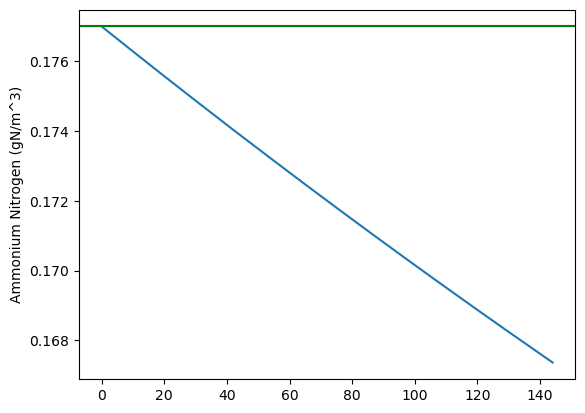

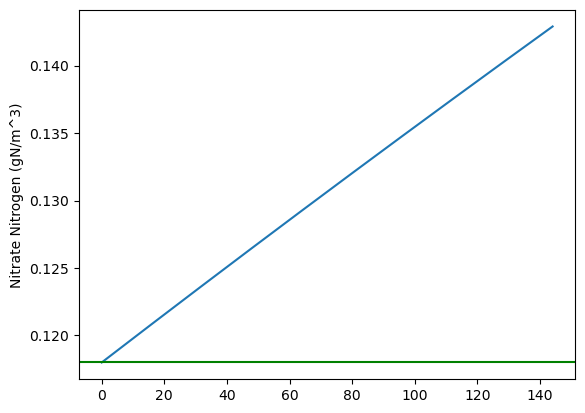

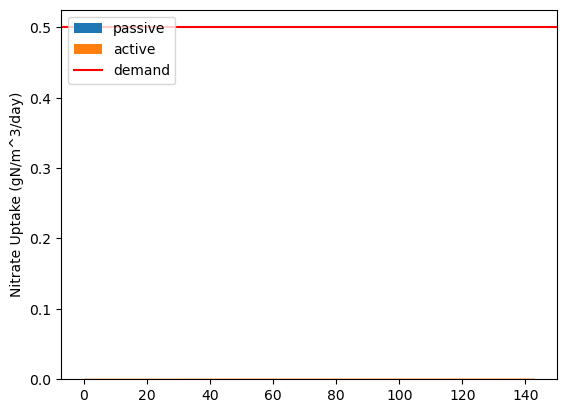

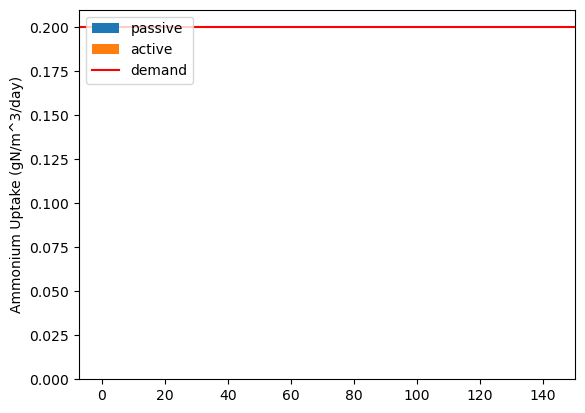

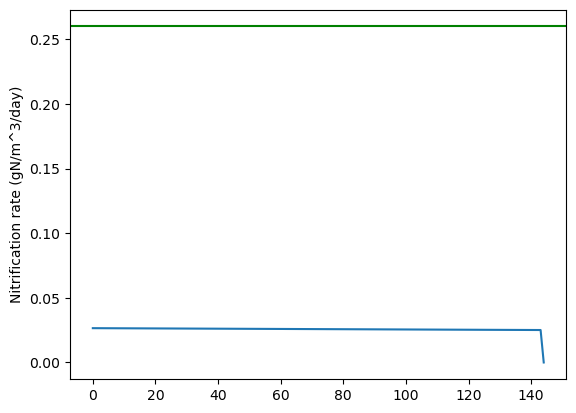

In [45]:
plt.figure()
plt.ylabel("Ammonium Nitrogen (gN/m^3)")
plt.plot(range(len(ammonium_nitrogen_g_per_m3)), ammonium_nitrogen_g_per_m3)
plt.axhline(y=0.177, color="green") # from https://link.springer.com/article/10.1007/s10705-017-9825-2, assuming ploughing
plt.figure()
plt.ylabel("Nitrate Nitrogen (gN/m^3)")
plt.plot(range(len(nitrate_nitrogen_g_per_m3)), nitrate_nitrogen_g_per_m3)
plt.axhline(y=0.118, color="green") # from https://link.springer.com/article/10.1007/s10705-017-9825-2, assuming ploughing
plt.figure()
plt.ylabel("Nitrate Uptake (gN/m^3/day)")
plt.stackplot(range(len(plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day)), plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day, plant_active_nitrate_uptake_rate_g_N_per_m3_per_day, labels=["passive", "active"])
plt.axhline(y=PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY, label="demand", color="red")
plt.legend(loc="upper left")
plt.figure()
plt.ylabel("Ammonium Uptake (gN/m^3/day)")
plt.stackplot(range(len(plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day)), plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day, plant_active_ammonium_uptake_rate_g_N_per_m3_per_day, labels=["passive", "active"])
plt.axhline(y=PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY, label="demand", color="red")
plt.legend(loc="upper left")
plt.figure()
plt.ylabel("Nitrification rate (gN/m^3/day)")
plt.plot(range(len(nitrification_rate_g_N_per_m3_per_day)), nitrification_rate_g_N_per_m3_per_day)
plt.axhline(y=0.26, color="green") # from https://link.springer.com/article/10.1007/s10705-017-9825-2/tables/1, assuming ploughing

# Sensitivity Analysis

In [46]:
def find_transition_probabilities(initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_soil_moisture: float, initial_litter_carbon_gC_per_m3: float, initial_litter_nitrogen_gN_per_m3: float, initial_microbial_carbon_gC_per_m3: float, initial_humus_carbon_gC_per_m3: float, n_trials: int = 200):
    end_ammonium = np.ndarray(n_trials)
    end_nitrate = np.ndarray(n_trials)
    for i in range(n_trials):
        rain_quantity_mm = generate_rain()
        soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor = hydrology_model(initial_soil_moisture, rain_quantity_mm)
        _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(NUM_DAYS_TOTAL), np.zeros(NUM_DAYS_TOTAL))
        ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, _, _, _, _, _, _, assumptions_violation, _ = inorganic_nitrogen_model(initial_ammonium_gN_per_m3, initial_nitrate_gN_per_m3, leakage_rate_mm_per_day, transpiration_rate_mm_per_day, soil_moisture, moisture_effect_on_nitrification_factor, moisture_effect_on_decomposition_factor, net_flux_to_mineralized_nitrogen_g_per_m3_per_day, biomass_carbon_g_per_m3, output_dt_days=(1/24 * 1/6))
        if any(assumptions_violation):
            print("Assumptions violated!")
            break
        end_ammonium[i] = ammonium_nitrogen_g_per_m3[-1]
        end_nitrate[i] = nitrate_nitrogen_g_per_m3[-1]
    return end_ammonium, end_nitrate

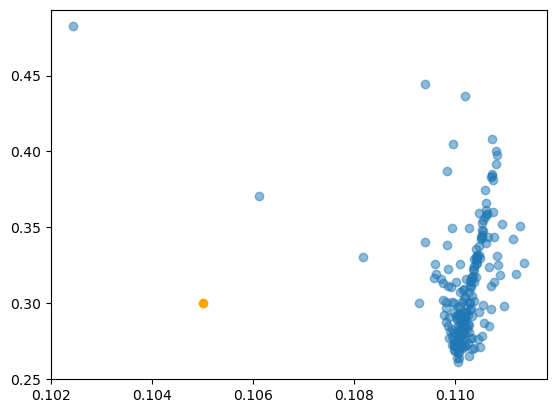

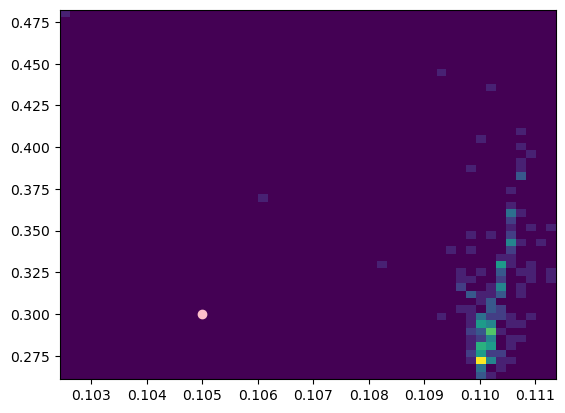

In [47]:
initial_ammonium = 0.105
initial_nitrate = 0.3
end_ammonium, end_nitrate = find_transition_probabilities(initial_ammonium, initial_nitrate, 0.15, 1300, 1300 / 34.0, 50, 8500)
plt.scatter(end_ammonium, end_nitrate, alpha=0.5)
plt.plot([initial_ammonium], [initial_nitrate], 'o', color="orange")
plt.figure()
plt.hist2d(end_ammonium, end_nitrate, bins=50)
plt.plot([initial_ammonium], [initial_nitrate], 'o', color="pink")

In [48]:
histograms = []
for initial_soil_moisture in np.linspace(start=0.05, stop=0.45, num=10):
    end_ammonium, end_nitrate = find_transition_probabilities(initial_ammonium, initial_nitrate, initial_soil_moisture, 1300, 1300 / 34.0, 50, 8500, n_trials=500)
    histograms.append((initial_soil_moisture, end_ammonium, end_nitrate))

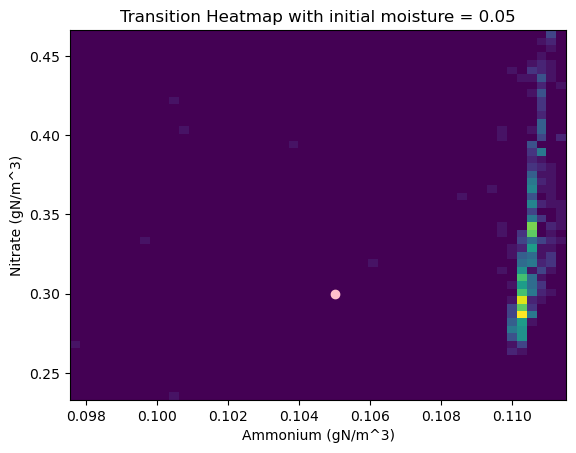

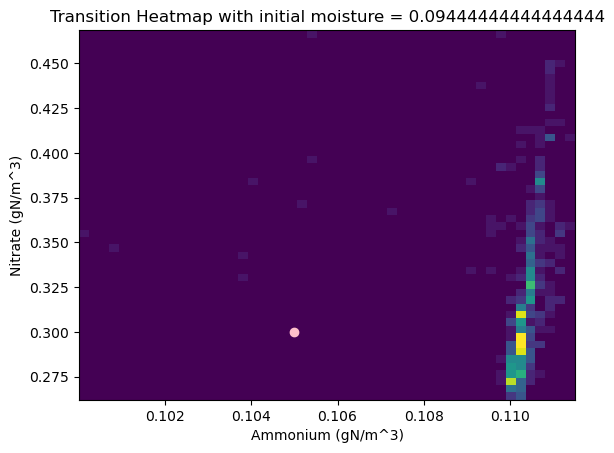

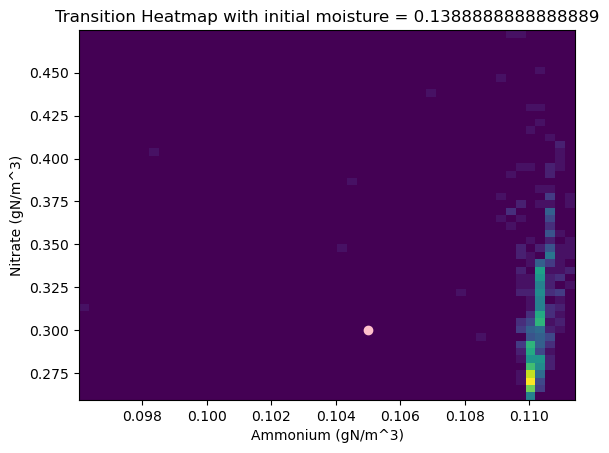

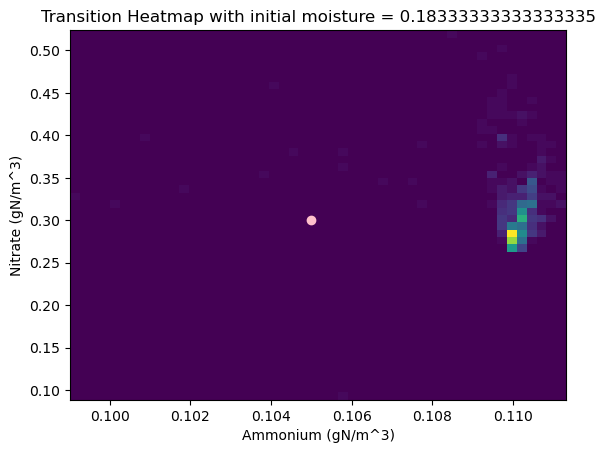

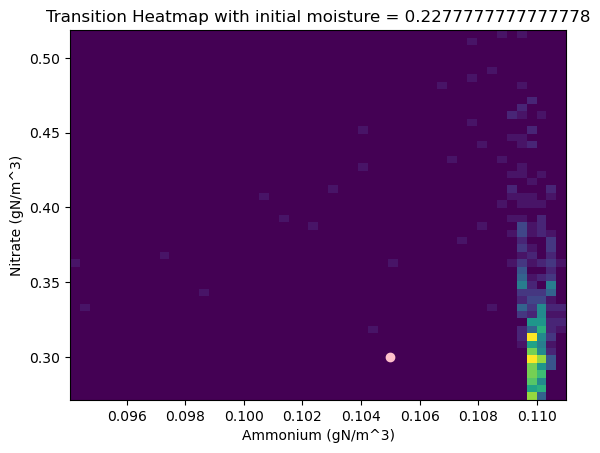

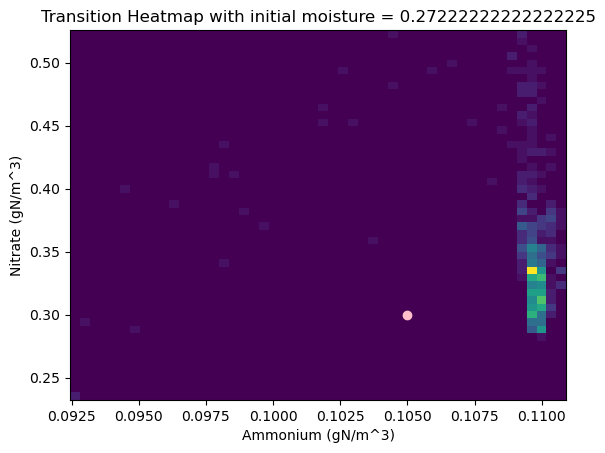

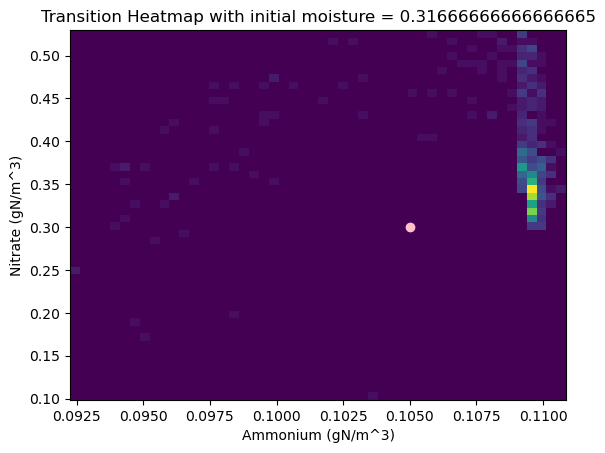

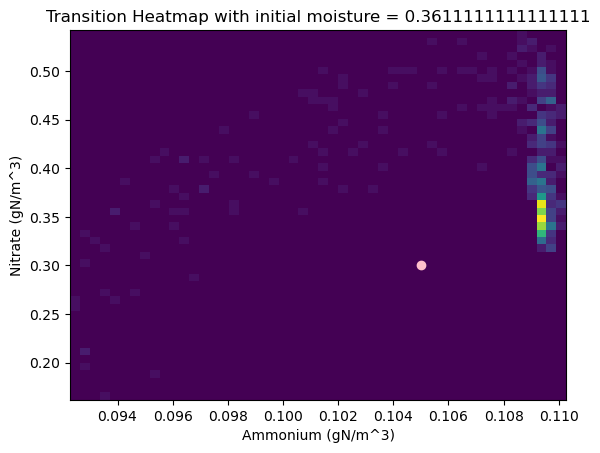

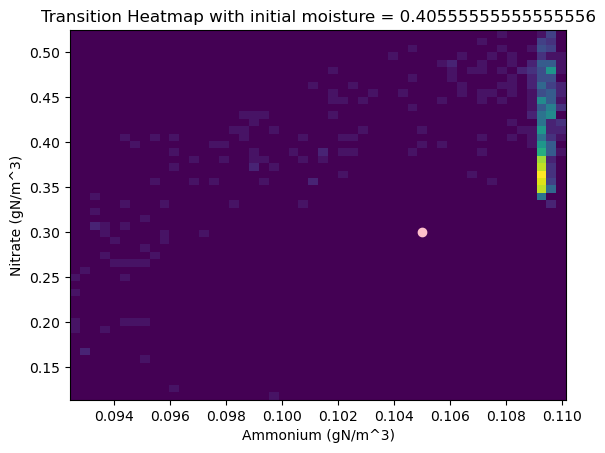

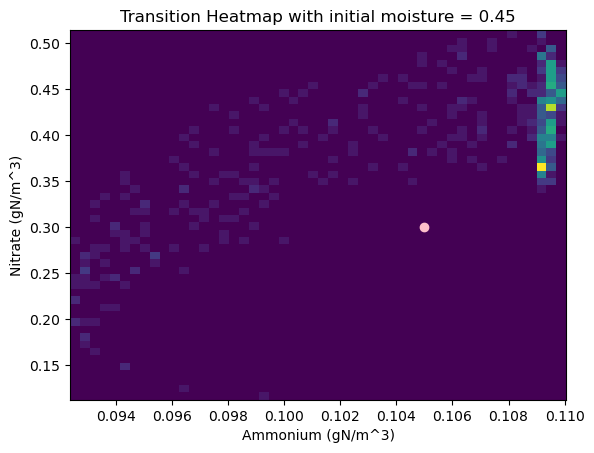

In [49]:
for initial_soil_moisture, ammonium_distribution, nitrate_distribution in histograms:
    plt.figure()
    plt.hist2d(ammonium_distribution, nitrate_distribution, bins=50)
    plt.xlabel("Ammonium (gN/m^3)")
    plt.ylabel("Nitrate (gN/m^3)")
    plt.title("Transition Heatmap with initial moisture = " + str(initial_soil_moisture))
    plt.plot([initial_ammonium], [initial_nitrate], 'o', color="pink")

In [50]:
histograms = []
for initial_biomass_carbon in np.linspace(start=40, stop=70, num=10):
    end_ammonium, end_nitrate = find_transition_probabilities(initial_ammonium, initial_nitrate, 0.15, 1300, 1300 / 34.0, initial_biomass_carbon, 8500, n_trials=1000)
    histograms.append((initial_biomass_carbon, end_ammonium, end_nitrate))

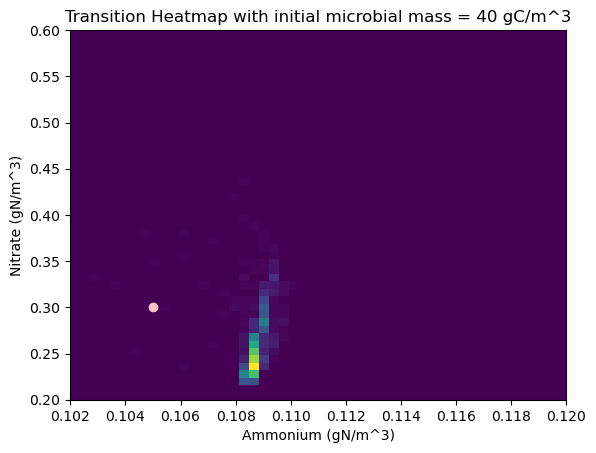

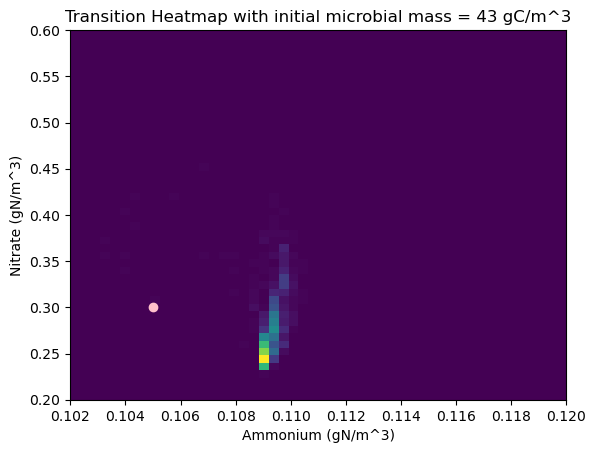

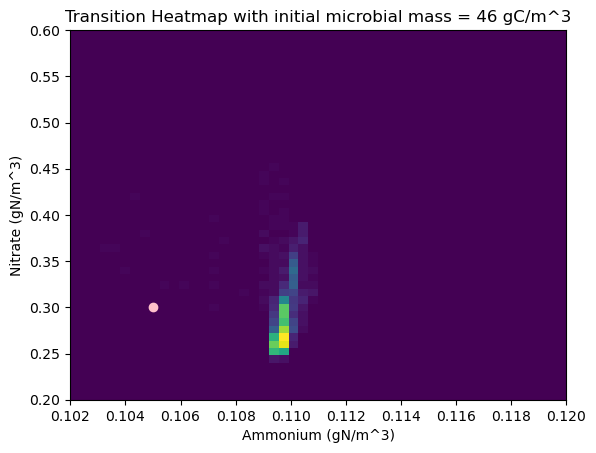

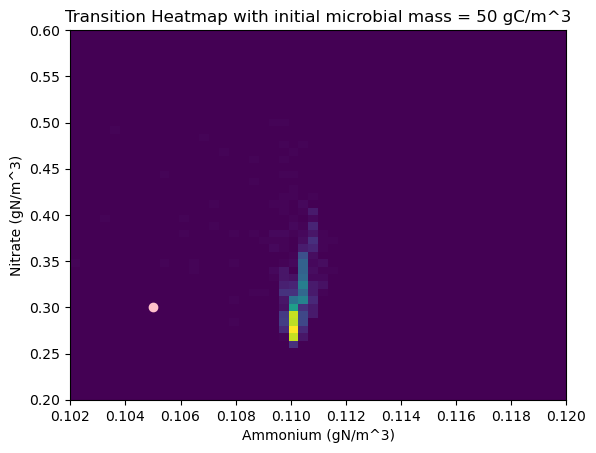

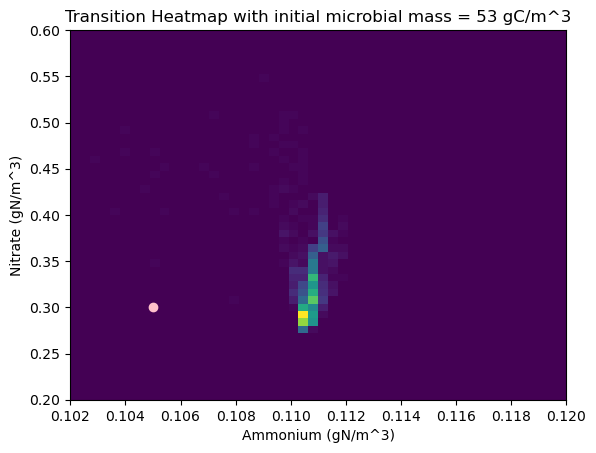

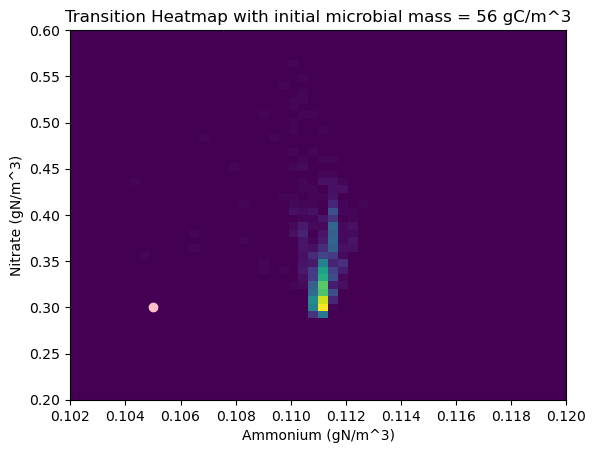

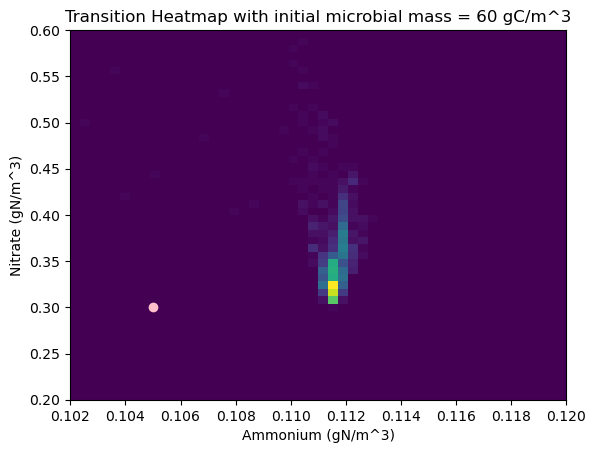

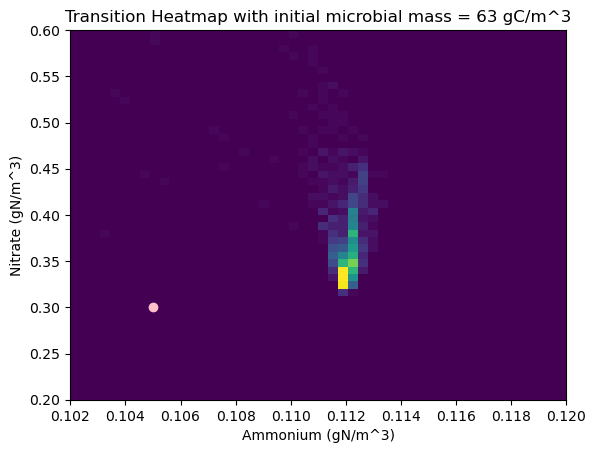

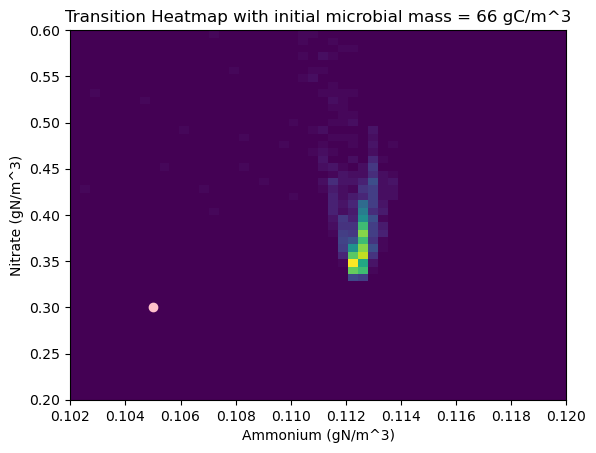

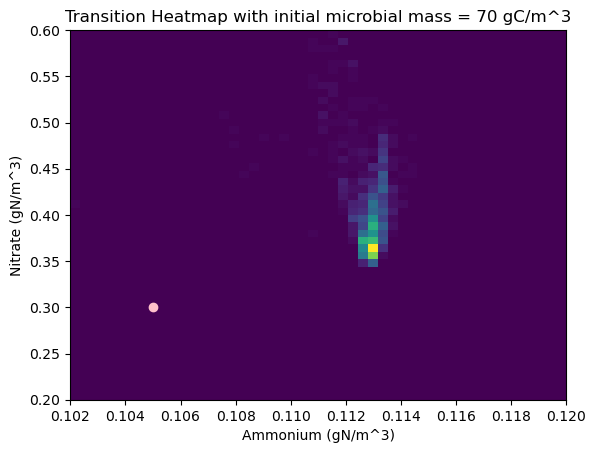

In [59]:
for initial_biomass_carbon, ammonium_distribution, nitrate_distribution in histograms:
    plt.figure()
    plt.hist2d(ammonium_distribution, nitrate_distribution, bins=50, range=[[0.102, 0.120], [0.2, 0.6]])
    plt.xlabel("Ammonium (gN/m^3)")
    plt.ylabel("Nitrate (gN/m^3)")
    plt.title("Transition Heatmap with initial microbial mass = {} gC/m^3".format(int(initial_biomass_carbon)))
    plt.plot([initial_ammonium], [initial_nitrate], 'o', color="pink")

In [1]:
n_trials = 100000
initial_moisture = np.linspace(0.05, 1.0, n_trials)
end_moisture = np.ndarray(n_trials)
for i in range(n_trials):
    rain_quantity_mm = generate_rain()
    soil_moisture, _, _, _, _, _, _ = hydrology_model(initial_moisture[i], rain_quantity_mm)
    end_moisture[i] = soil_moisture[-1]

NameError: name 'np' is not defined

Text(0, 0.5, 'Moisture 1 month later')

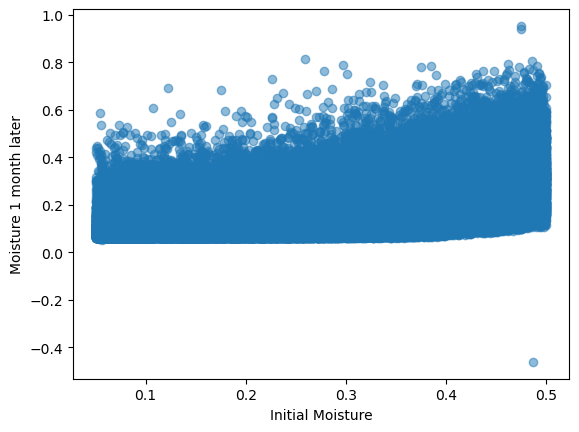

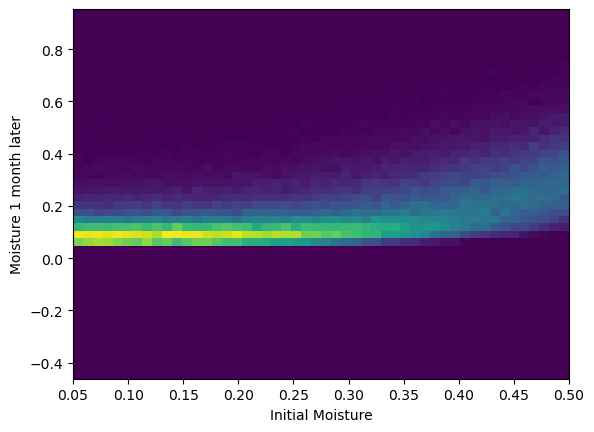

In [53]:
plt.scatter(initial_moisture, end_moisture, alpha=0.5)
plt.xlabel("Initial Moisture")
plt.ylabel("Moisture 1 month later")
plt.figure()
plt.hist2d(initial_moisture, end_moisture, bins=50)
plt.xlabel("Initial Moisture")
plt.ylabel("Moisture 1 month later")

In [54]:
n_trials = 100000
start_carbon = np.linspace(40, 70, n_trials)
end_carbon = np.ndarray(n_trials)
for i in range(n_trials):
    rain_quantity_mm = generate_rain()
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor = hydrology_model(0.15, rain_quantity_mm)
    _, _, biomass_carbon_g_per_m3, _, _ = soil_organic_model(1300, 1300 / 34.0, start_carbon[i], 8500, moisture_effect_on_decomposition_factor, np.zeros(NUM_DAYS_TOTAL), np.zeros(NUM_DAYS_TOTAL))
    end_carbon[i] = biomass_carbon_g_per_m3[-1]

Text(0, 0.5, 'Carbon 1 month later')

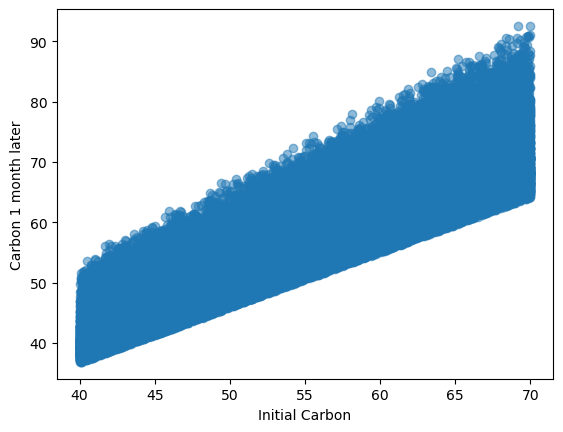

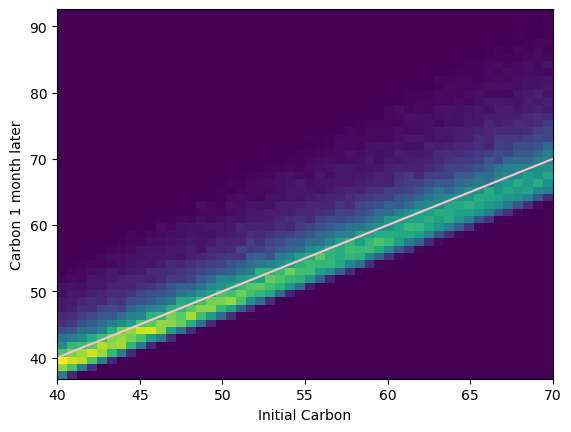

In [55]:
plt.scatter(start_carbon, end_carbon, alpha=0.5)
plt.xlabel("Initial Carbon")
plt.ylabel("Carbon 1 month later")
# plt.ylim(35, 75)
plt.figure()
plt.hist2d(start_carbon, end_carbon, bins=50)
plt.plot([40, 70], [40, 70], color="pink")
plt.xlabel("Initial Carbon")
plt.ylabel("Carbon 1 month later")
# plt.ylim(35, 75)

# Soil C/N Dynamics

In [56]:
for i in range(NUM_DAYS_TOTAL):
    litter_cn_ratio[i] = litter_carbon_g_per_m3[i] / litter_nitrogen_g_per_m3[i]
    humified_fraction_of_decomposed_litter[i] = min(MAX_HUMIFIED_FRACTION_OF_DECOMPOSED_LITTER, HUMUS_CN_RATIO / litter_cn_ratio[i])
    biomassified_fraction_of_decomposed_litter_carbon[i] = 1.0 - RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON - humified_fraction_of_decomposed_litter[i]
    available_mineral_nitrogen_g_per_m3_per_day[i] = MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_nitrogen_g_per_m3[i] + MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_nitrogen_g_per_m3[i]
    maximum_immobilization_rate_g_N_per_m3_per_day[i] = available_mineral_nitrogen_g_per_m3_per_day[i] * moisture_effect_on_decomposition_factor[i] # Porporato has an extra `* litter_carbon_g_per_m3[i]` but that breaks mass balance
    surplus_N_at_max_decomposition_rate_g_N_per_biomass_per_day_per_m3[i] = PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY * humus_carbon_g_per_m3[i] * (1 / HUMUS_CN_RATIO - NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON / BIOMASS_CN_RATIO) + PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY * litter_carbon_g_per_m3[i] * (1 / litter_cn_ratio[i] - humified_fraction_of_decomposed_litter[i] / HUMUS_CN_RATIO - biomassified_fraction_of_decomposed_litter_carbon[i] / BIOMASS_CN_RATIO)
    immobilization_demand_g_N_per_m3_per_day[i] = moisture_effect_on_decomposition_factor[i] * -surplus_N_at_max_decomposition_rate_g_N_per_biomass_per_day_per_m3[i] * biomass_carbon_g_per_m3[i]

    if surplus_N_at_max_decomposition_rate_g_N_per_biomass_per_day_per_m3[i] >= 0 or immobilization_demand_g_N_per_m3_per_day[i] <= maximum_immobilization_rate_g_N_per_m3_per_day[i]:
        phi[i] = 1.0
    else:
        print("phi != 1")
        phi[i] = maximum_immobilization_rate_g_N_per_m3_per_day[i] / immobilization_demand_g_N_per_m3_per_day[i]
    # print_step(i)

    added_residues_g_C_per_m3_per_day[i] = ADDED_RESIDUE_CARBON_G_PER_M2_PER_DAY / (SOIL_DEPTH_MM / 1000.0)

    # Decay flows
    biomass_death_rate_g_carbon_per_m3_per_day[i] = PROPORTION_BIOMASS_DYING_PER_DAY * biomass_carbon_g_per_m3[i]
    litter_decomposition_rate_g_carbon_per_m3_per_day[i] = phi[i] * moisture_effect_on_decomposition_factor[i] * PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY * biomass_carbon_g_per_m3[i] * litter_carbon_g_per_m3[i]
    humus_decomposition_rate_g_carbon_per_m3_per_day[i] = phi[i] * moisture_effect_on_decomposition_factor[i] * PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY * biomass_carbon_g_per_m3[i] * humus_carbon_g_per_m3[i]

    # immobilization/mineralization flows
    net_flux_to_mineralized_nitrogen_g_per_m3_per_day[i] = humus_decomposition_rate_g_carbon_per_m3_per_day[i] * (1 / HUMUS_CN_RATIO - NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON / BIOMASS_CN_RATIO) + litter_decomposition_rate_g_carbon_per_m3_per_day[i] * (1 / litter_cn_ratio[i] - humified_fraction_of_decomposed_litter[i] / HUMUS_CN_RATIO - biomassified_fraction_of_decomposed_litter_carbon[i] / BIOMASS_CN_RATIO)
    if net_flux_to_mineralized_nitrogen_g_per_m3_per_day[i] > 0:
        mineralization_rate_g_N_per_m3_per_day[i] = net_flux_to_mineralized_nitrogen_g_per_m3_per_day[i]
        total_immobilization_rate_g_N_per_m3_per_day[i] = 0
    else:
        mineralization_rate_g_N_per_m3_per_day[i] = 0
        total_immobilization_rate_g_N_per_m3_per_day[i] = -net_flux_to_mineralized_nitrogen_g_per_m3_per_day[i]
    ammonium_immobilization_rate_g_N_per_m3_per_day[i] = MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_nitrogen_g_per_m3[i] / available_mineral_nitrogen_g_per_m3_per_day[i] * total_immobilization_rate_g_N_per_m3_per_day[i]
    nitrate_immobilization_rate_g_N_per_m3_per_day[i] = MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_nitrogen_g_per_m3[i] / available_mineral_nitrogen_g_per_m3_per_day[i] * total_immobilization_rate_g_N_per_m3_per_day[i]

    # Plant uptake
    plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * transpiration_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * ammonium_nitrogen_g_per_m3[i]
    plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_NITRATE * transpiration_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * nitrate_nitrogen_g_per_m3[i]
    max_active_ammonium_uptake_g_N_per_m3_per_day[i] = max_active_ammonium_uptake_proportion_per_day[i] * ammonium_nitrogen_g_per_m3[i]
    max_active_nitrate_uptake_g_N_per_m3_per_day[i] = max_active_nitrate_uptake_proportion_per_day[i] * nitrate_nitrogen_g_per_m3[i]

    if plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i] > PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY:
        plant_active_ammonium_uptake_rate_g_N_per_m3_per_day[i] = 0
    elif PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY < max_active_ammonium_uptake_g_N_per_m3_per_day[i] + plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i]:
        plant_active_ammonium_uptake_rate_g_N_per_m3_per_day[i] = PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY - plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i]
    else:
        plant_active_ammonium_uptake_rate_g_N_per_m3_per_day[i] = max_active_ammonium_uptake_g_N_per_m3_per_day[i]

    if plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i] > PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY:
        plant_active_nitrate_uptake_rate_g_N_per_m3_per_day[i] = 0
    elif PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY < max_active_nitrate_uptake_g_N_per_m3_per_day[i] + plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i]:
        plant_active_nitrate_uptake_rate_g_N_per_m3_per_day[i] = PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY - plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i]
    else:
        plant_active_nitrate_uptake_rate_g_N_per_m3_per_day[i] = max_active_nitrate_uptake_g_N_per_m3_per_day[i]

    ammonium_uptake_rate_g_N_per_m3_per_day[i] = plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i] + plant_active_ammonium_uptake_rate_g_N_per_m3_per_day[i]
    nitrate_uptake_rate_g_N_per_m3_per_day[i] = plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i] + plant_active_nitrate_uptake_rate_g_N_per_m3_per_day[i]

    # leaching
    ammonium_leaching_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * leakage_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * ammonium_nitrogen_g_per_m3[i]
    nitrate_leaching_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_NITRATE * leakage_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * nitrate_nitrogen_g_per_m3[i]

    # nitrification
    nitrification_rate_g_N_per_m3_per_day[i] = moisture_effect_on_nitrification_factor[i] * PROPORTION_AMMONIUM_NITRIFIED_PER_BIOMASS_PER_DAY * biomass_carbon_g_per_m3[i] * ammonium_nitrogen_g_per_m3[i]
    if (ammonium_immobilization_rate_g_N_per_m3_per_day[i] + nitrification_rate_g_N_per_m3_per_day[i] + ammonium_leaching_rate_g_N_per_m3_per_day[i] + ammonium_uptake_rate_g_N_per_m3_per_day[i] - mineralization_rate_g_N_per_m3_per_day[i]) > ammonium_nitrogen_g_per_m3[i]: # cap nitrification at max possible
        nitrification_rate_g_N_per_m3_per_day[i] = ammonium_nitrogen_g_per_m3[i] + mineralization_rate_g_N_per_m3_per_day[i] - ammonium_immobilization_rate_g_N_per_m3_per_day[i] - ammonium_leaching_rate_g_N_per_m3_per_day[i] - ammonium_uptake_rate_g_N_per_m3_per_day[i]

    # Update states
    if (i + 1) < NUM_DAYS_TOTAL:
        litter_carbon_g_per_m3[i + 1] = litter_carbon_g_per_m3[i] + added_residues_g_C_per_m3_per_day[i] + biomass_death_rate_g_carbon_per_m3_per_day[i] - litter_decomposition_rate_g_carbon_per_m3_per_day[i]
        litter_nitrogen_g_per_m3[i + 1] = litter_nitrogen_g_per_m3[i] + added_residues_g_C_per_m3_per_day[i] / ADDED_RESIDUE_CN_RATIO + biomass_death_rate_g_carbon_per_m3_per_day[i] / BIOMASS_CN_RATIO - litter_decomposition_rate_g_carbon_per_m3_per_day[i] / litter_cn_ratio[i]
        humus_carbon_g_per_m3[i + 1] = humus_carbon_g_per_m3[i] + humified_fraction_of_decomposed_litter[i] * litter_decomposition_rate_g_carbon_per_m3_per_day[i] - humus_decomposition_rate_g_carbon_per_m3_per_day[i]
        humus_nitrogen_g_per_m3[i + 1] = humus_carbon_g_per_m3[i + 1] / HUMUS_CN_RATIO
        biomass_carbon_g_per_m3[i + 1] = biomass_carbon_g_per_m3[i] + biomassified_fraction_of_decomposed_litter_carbon[i] * litter_decomposition_rate_g_carbon_per_m3_per_day[i] + (1 - RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON) * humus_decomposition_rate_g_carbon_per_m3_per_day[i] - biomass_death_rate_g_carbon_per_m3_per_day[i]
        biomass_nitrogen_g_per_m3[i + 1] = biomass_carbon_g_per_m3[i + 1] / BIOMASS_CN_RATIO
        ammonium_nitrogen_g_per_m3[i + 1] = max(0, ammonium_nitrogen_g_per_m3[i] + mineralization_rate_g_N_per_m3_per_day[i] - ammonium_immobilization_rate_g_N_per_m3_per_day[i] - nitrification_rate_g_N_per_m3_per_day[i] - ammonium_leaching_rate_g_N_per_m3_per_day[i] - ammonium_uptake_rate_g_N_per_m3_per_day[i])
        nitrate_nitrogen_g_per_m3[i + 1] = nitrate_nitrogen_g_per_m3[i] + nitrification_rate_g_N_per_m3_per_day[i] - nitrate_immobilization_rate_g_N_per_m3_per_day[i] - nitrate_leaching_rate_g_N_per_m3_per_day[i] - nitrate_uptake_rate_g_N_per_m3_per_day[i]

/tmp/nix-shell.Ice7eQ/ipykernel_1662200/204205139.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * transpiration_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * ammonium_nitrogen_g_per_m3[i]
/tmp/nix-shell.Ice7eQ/ipykernel_1662200/204205139.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_NITRATE * transpiration_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * nitrate_nitrogen_g_per_m3[i]
/tmp/nix-shell.Ice7eQ/ipykernel_1662200/204205139.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  ammonium_leaching_rate_g_N_per_m3_per_day[i] = DISSOLVED_FRACTION_AMMONIUM * leakage_rate_mm_per_day[i] / volume_water_per_unit_area_mm[i] * ammonium_nitrogen_g_per_m3[i]
/tmp/nix-shell.Ice7eQ/ipykernel_1662200/204205139.py:60: RuntimeWarning: divide by zero encounter

ValueError: x and y must have same first dimension, but have shapes (30,) and (4320,)

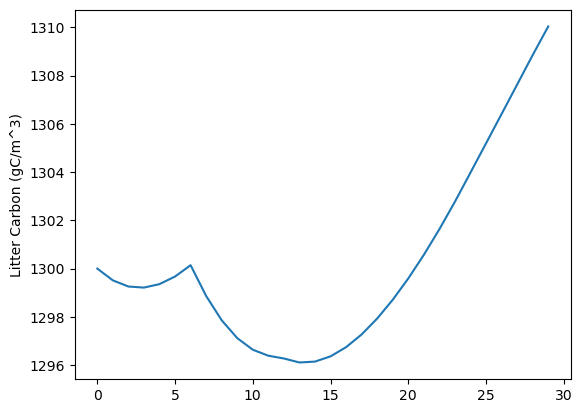

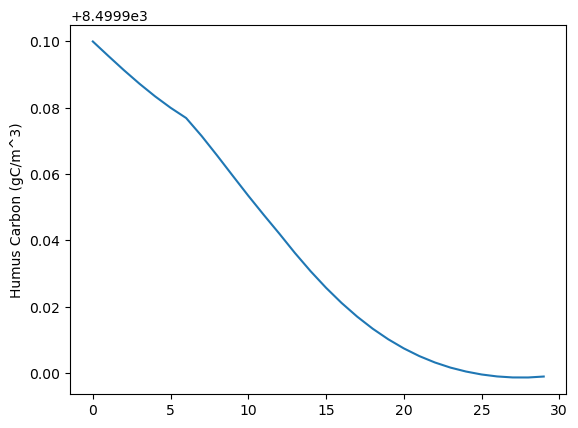

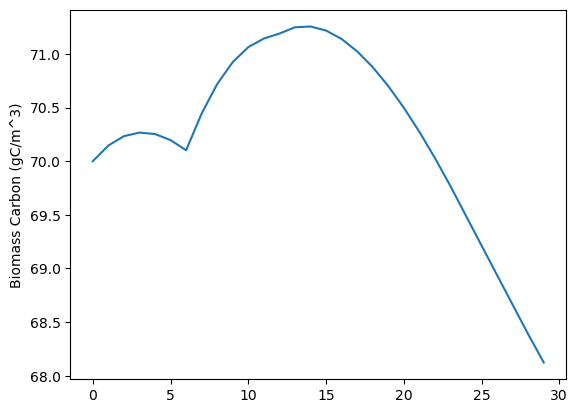

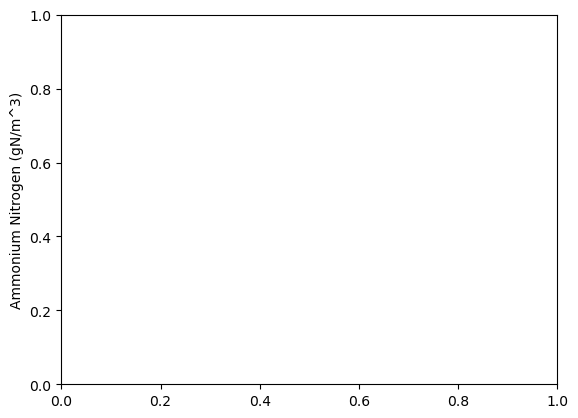

In [57]:
plt.figure()
plt.ylabel("Litter Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), litter_carbon_g_per_m3)
plt.figure()
plt.ylabel("Humus Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), humus_carbon_g_per_m3)
plt.figure()
plt.ylabel("Biomass Carbon (gC/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), biomass_carbon_g_per_m3)
plt.figure()
plt.ylabel("Ammonium Nitrogen (gN/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), ammonium_nitrogen_g_per_m3)
plt.figure()
plt.ylabel("Nitrate Nitrogen (gN/m^3)")
plt.plot(range(NUM_DAYS_TOTAL), nitrate_nitrogen_g_per_m3)
plt.figure()
plt.ylabel("Litter Decomposition Rate (gC/m^3/day)")
plt.plot(range(NUM_DAYS_TOTAL), litter_decomposition_rate_g_carbon_per_m3_per_day)
plt.figure()
plt.ylabel("Mineralization Rate (gN/m^3/day)")
plt.plot(range(NUM_DAYS_TOTAL), mineralization_rate_g_N_per_m3_per_day)
plt.figure()
plt.ylabel("C/N ratio")
plt.plot(range(NUM_DAYS_TOTAL), litter_cn_ratio, label="Litter")
plt.axhline(y=BIOMASS_CN_RATIO, label="Biomass", color="g")
plt.axhline(y=HUMUS_CN_RATIO, label="Humus", color="orange")
plt.legend()
plt.figure()
plt.ylabel("Nitrate Uptake (gN/m^3/day)")
plt.stackplot(range(NUM_DAYS_TOTAL), plant_passive_nitrate_uptake_rate_g_N_per_m3_per_day, plant_active_nitrate_uptake_rate_g_N_per_m3_per_day, labels=["passive", "active"])
plt.axhline(y=PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY, label="demand", color="red")
plt.legend(loc="upper left")
plt.figure()
plt.ylabel("Ammonium Uptake (gN/m^3/day)")
plt.stackplot(range(NUM_DAYS_TOTAL), plant_passive_ammonium_uptake_rate_g_N_per_m3_per_day, plant_active_ammonium_uptake_rate_g_N_per_m3_per_day, labels=["passive", "active"])
plt.axhline(y=PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY, label="demand", color="red")
plt.legend(loc="upper left")
plt.figure()
plt.ylabel("Nitrate outflows (gN/m^3/day)")
plt.stackplot(range(NUM_DAYS_TOTAL), nitrate_immobilization_rate_g_N_per_m3_per_day, nitrate_leaching_rate_g_N_per_m3_per_day, nitrate_uptake_rate_g_N_per_m3_per_day, labels=["immobilization", "leaching", "uptake"])
plt.legend(loc="upper right")